<a id='introduction'></a> 
# INTRODUCTION

In [1]:
#%matplotlib inline
#%matplotlib notebook
# Imports

import urllib.request
import numpy as np
import pandas
import datetime
import os
import cdflib
import cdflib.epochs as epoch
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import load_cdf as loader # also contains other functions from this notebook


<a id='descriptions'></a> 
## Brief descriptions

### 1. RPW/TDS block diagram

<img src=./Pictures/solo_tds_block.png  width=90%>    
<br>

### 2. Spacecraft Reference Frame (SRF)

<br>
<img src=./Pictures/SRF.png  width=70%>    
<br>




<a id='data'></a> 
## Data functions  

In [2]:
# Loading downloaded cdf files
def load_tswf(date):
    """
        Loading TDS-SURV-TSWF-E CDF file
        date - desired date as datetime.datetime(year, month, day) where 
            year - given year (>=2020)
            month - given month (1-12)
            day - give day (1-31)
    """
    filetype = 'tswf'

    year = date.year
    month = date.month
    day = date.day
    data_folder = os.path.join(os.getcwd(), 'Downloads')
    for names in os.listdir(os.path.join('Download', ('%04d' % year), ('%02d' % month))):
        if ('solo_L2_rpw-tds-surv-%s-e_%04d%02d%02d_V' % (filetype, year, month, day)) in names:
            fname = names
    print('loading ' + fname)
    cdf = cdflib.CDF(os.path.join('Download', ('%04d' % year), ('%02d' % month), fname))

    data = {}
    info = cdf.cdf_info()
    varnames = info['zVariables']
    for varname in varnames:
        data[varname] = cdf.varget(varname)
    return data


# Convering to SRF
def convert_to_SRF(data, index=0):
    """ 
        Convert TDS SWF from the antenna to the spacecraft 
        reference frame (SRF).
        Using the effective antenna directions
        two components of the E-field in the Y-Z SRF plane
        are calculated for the given TDS configuration.
        data(ncomp, nsamples) - loaded TDS cdf file containing data in the ANT coordiate system
        index - a snapshot number to be transformed, the first is default
        E(2,nsamples) - 2D E-field E[0, *] = Ey, E[1, *] = Ez
    """
    nsamp = data['SAMPS_PER_CH'][index]
    tds_mode = data['TDS_CONFIG_LABEL'][index]
    if 'SE1' in tds_mode:
        # Pachenko's antenna angle
        pacang = np.deg2rad(125)
        V1 = [0, 1]
        # Pachenko monopole antennas
        V2 = [np.sin(pacang), np.cos(pacang)]
        V3 = [-np.sin(pacang), np.cos(pacang)]
        # SE1 TDS mode
        M = np.array([V1, V2])  # [CH1, CH2]
    else:
        pacang = np.deg2rad(158.1)
        ant21 = [np.sin(pacang), np.cos(pacang)]  # E - field in the same sense.
        pacang = np.deg2rad(-158.2)
        ant13 = [-np.sin(pacang), -np.cos(pacang)]  # ant31 then - 1. to ant13
        M = np.array([ant13, ant21])  # [CH1, CH2]

    ww = data['WAVEFORM_DATA'][index, :, 0:nsamp]
    # projection: E = MAT(ANT->SRF) * V; where MAT(2,2) and V is observed field
    M = np.linalg.inv(M)
    E = np.dot(M, ww[0:2, :]) * 1e3  # transformation into SRF (Y-Z) in (mV/m)
    return E


In [3]:
# Waveform plot
def plot_waveform(ww, t0, sr):
    """
        Plotting the TDS-TSWF waveform snapshots
        ww - electric field data in SRF coordinate system: 2D E-field E[0, *] = Ey, E[1, *] = Ez
        t0 - time of snapshot: Epoch
        sr - sampling rate
    """
    nsamp = int(ww.size/2)
    timestr = t0.strftime('%Y/%m/%d, %H:%M:%S.%f')
    tt = np.arange(0, nsamp/sr, 1/sr)*1e3
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6), dpi=80)
    ax1.plot(tt,ww[0, :])
    ax1.set(ylabel='$EY_{SRF}$ (mV/m)')
    
    ax2.plot(tt,ww[1, :])
    ax2.set(ylabel='$EZ_{SRF}$ (mV/m)')
    plt.xlabel('Time since trigger (ms)')
    plt.suptitle(('TDS-TSWF waveforms in SRF: %s SWF#%d' % (timestr, rec)))
    plt.xlim(0, nsamp/sr*1e3)
    plt.show()

    
# Spectrum
def plot_spectrum(ww, t0, sr):
    """
        Plotting the TDS-TSWF spectra computed from Ey and Ez SRF 
        ww - electric field data in SRF coordinate system: 2D E-field E[0, *] = Ey, E[1, *] = Ez
        t0 - time of snapshot: Epoch
        sr - sampling rate
    """
    figure(figsize=(8, 6), dpi=80)
    nsamp = int(ww.size/2)
    tt = np.arange(0, nsamp/sr, 1/sr)
    fourier_transform = np.fft.rfft(ww)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sr / 2, len(power_spectrum[0,:]))
    xmin = (np.abs(frequency - 200)).argmin()
    if sr>300000:
        fmax = 200000
    else:
        fmax = 100000
    xmax = (np.abs(frequency - fmax)).argmin()
    
    plt.plot(frequency[xmin:xmax]*1e-3, power_spectrum[0, xmin:xmax])
    plt.plot(frequency[xmin:xmax]*1e-3, power_spectrum[1, xmin:xmax])
    plt.legend(['$EY_{SRF}$','$EZ_{SRF}$'])
    
    plt.yscale("log")
    plt.xlim(2, fmax*1e-3)
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Power spectral density')
    timestr = t0.strftime('%Y/%m/%d, %H:%M:%S.%f')
    plt.title(('SolO TDS TSWF spectrum  %s SWF#%d' % (timestr, rec)))
    

# Hodogram
def plot_hodogram(ww, t0, size=200, samp=-1):
    """
        Plotting a hodogram from Ey-Ez components 
        ww - electric field data in SRF coordinate system: 2D E-field E[0, *] = Ey, E[1, *] = Ez
        t0 - time of snapshot: Epoch
        size - number of samples to be plotted
        samp - the center index to specify which part of waveform will be plotted
    """
    figure(figsize=(8, 6), dpi=80)
    nsamp = int(ww.size/2)
    if samp == -1:
        amp = np.abs(ww[0, :]) + np.abs(ww[1, :])
        samp = np.argmax(amp)
        if samp<size/2:
            samp = 251
        elif samp>nsamp-(size/2):
            samp = nsamp-251

    if samp < size / 2:
        samp = size + 1
    elif samp > nsamp - (size / 2):
        samp = nsamp - size - 1

    y = ww[0, int(samp-size):int(samp+size/2)]
    z = ww[1, int(samp-size):int(samp+size/2)]
    
    plt.plot(y,z)
    m = ww.max()*1.1
    plt.gca().set_aspect('equal')
    plt.xlim(-m,m)
    plt.ylim(-m,m)
    plt.xlabel('$EY_{SRF}$ (mV/m)')
    plt.ylabel('$EZ_{SRF}$ (mV/m)')
    timestr = t0.strftime('%Y/%m/%d, %H:%M:%S.%f')
    plt.title(('SolO TDS TSWF hodogram %s SWF#%d' % (timestr, rec)))
    plt.show()
    

# Examples

## Download, load cdf file and convert waveforms into SRF

In [4]:
"""
    Downloading TDS-SURV-TSWF cdf file for a given date.
    !! The file might have a size of several hundreds of MB
"""
date = datetime.datetime(2021,10,9)
loader.download_tswf(date) # Downloads from SOAR archive
tswf = load_tswf(date)
ww = convert_to_SRF(tswf, 0) # Converts the first snapshot to SRF

solo_L2_rpw-tds-surv-tswf-e_20211009item 1/1

downloading cdf file from http://soar.esac.esa.int/soar-sl-tap/data?retrieval_type=LAST_PRODUCT&data_item_id=solo_L2_rpw-tds-surv-tswf-e_20211009&product_type=SCIENCE
download complete
loading solo_L2_rpw-tds-surv-tswf-e_20211009_V01.cdf


## Plot waveform

loading solo_L2_rpw-tds-surv-tswf-e_20211009_V01.cdf


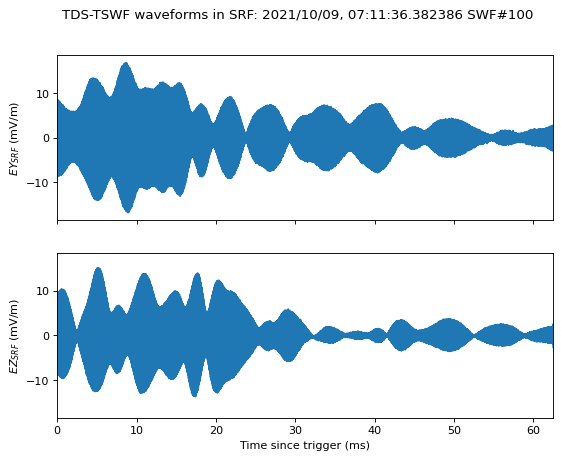

In [5]:
# Waveform plot
"""
    Plot TDS-TSWF waveform snapshot
"""
rec = 100 # snapshot #101

date = datetime.datetime(2021,10,9)
tswf = load_tswf(date)

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_waveform(ww, t0, sr)

## Plot spectrum

loading solo_L2_rpw-tds-surv-tswf-e_20211009_V01.cdf


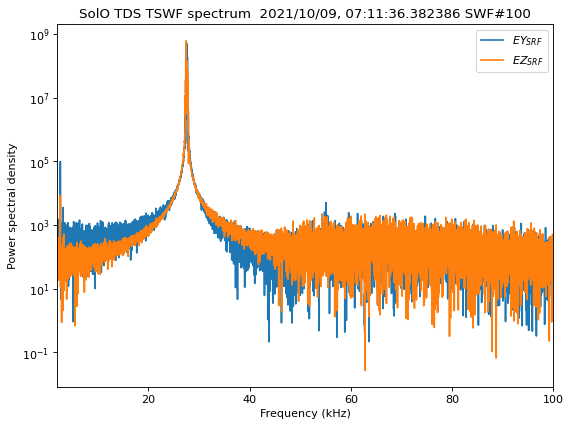

In [6]:
# Spectrum plot
"""
    Plot TDS-TSWF spectrum computed from Ey and Ez SRF
"""
rec = 100 # snapshot #101

date = datetime.datetime(2021,10,9)
tswf = load_tswf(date)

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_spectrum(ww, t0, sr)

## Plot hodogram


loading solo_L2_rpw-tds-surv-tswf-e_20211009_V01.cdf


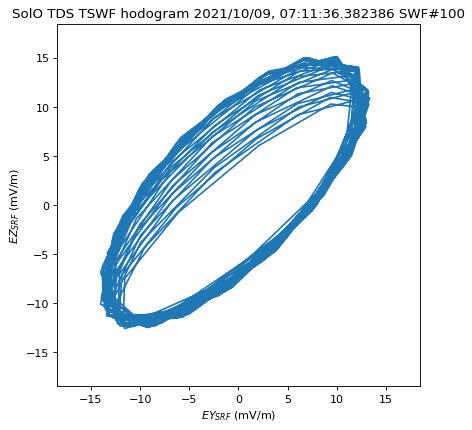

In [7]:
# Hodogram plot
"""
    Plot TDS-TSWF hodogram from Ey-Ez component
"""
rec = 100 # snapshot #101

date = datetime.datetime(2021,10,9)
tswf = load_tswf(date)

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_hodogram(ww, t0) # snapshot 101, length = 200 (default), center chosen at maximum

loading solo_L2_rpw-tds-surv-tswf-e_20211009_V01.cdf


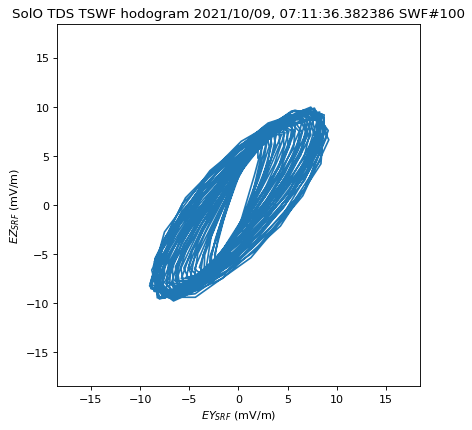

In [8]:
# Manual Hodogram plot
"""
    Plot TDS-TSWF snapshot
"""
rec = 100 # snapshot #101

date = datetime.datetime(2021,10,9)
tswf = load_tswf(date)

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_hodogram(ww, t0, 300, 6000) # snapshot 100, length 300, center 6000